In [1]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import timm
import torch.nn.functional as F

In [2]:
image_paths = './Data/1./*/*'
image_paths = glob(image_paths)

In [3]:
image_paths

['./Data/1./Glaucoma/images-30.jpeg',
 './Data/1./Glaucoma/image-3.jpeg',
 './Data/1./Glaucoma/images-71.jpeg',
 './Data/1./Glaucoma/images-26.jpeg',
 './Data/1./Glaucoma/images-3.jpeg',
 './Data/1./Glaucoma/images-51.jpeg',
 './Data/1./Glaucoma/images-10.jpeg',
 './Data/1./Glaucoma/images-47.jpeg',
 './Data/1./Glaucoma/images-46.jpeg',
 './Data/1./Glaucoma/images-11.jpeg',
 './Data/1./Glaucoma/images-50.jpeg',
 './Data/1./Glaucoma/images.jpeg',
 './Data/1./Glaucoma/images-2.jpeg',
 './Data/1./Glaucoma/images-27.jpeg',
 './Data/1./Glaucoma/images-70.jpeg',
 './Data/1./Glaucoma/image-2.jpeg',
 './Data/1./Glaucoma/images-66.jpeg',
 './Data/1./Glaucoma/images-31.jpeg',
 './Data/1./Glaucoma/image-9.jpeg',
 './Data/1./Glaucoma/images-5.jpeg',
 './Data/1./Glaucoma/image-12.jpeg',
 './Data/1./Glaucoma/images-57.jpeg',
 './Data/1./Glaucoma/images-16.jpeg',
 './Data/1./Glaucoma/images-41.jpeg',
 './Data/1./Glaucoma/images-36.jpeg',
 './Data/1./Glaucoma/image-5.jpeg',
 './Data/1./Glaucoma/images

In [4]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[3]
    image = image_path.split(os.path.sep)[4]
    labels.append(label)
    images.append(image)

In [5]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 4)))
pred2label = dict(zip(range(0, 4), np.unique(labels)))
n_classes = len(np.unique(labels))

In [6]:
class IrisDisease(torch.utils.data.Dataset):
    
    def __init__(self, image_paths, labels, transforms=None):
        super(IrisDisease, self).__init__()
        
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
            
        label = self.labels[idx]
        label = label2pred[label]
        label = torch.tensor(label)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, label        

In [7]:
device='mps'

In [8]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=42)

In [9]:
tr_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(1.0),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.RandomRotation(60),
    torchvision.transforms.RandomVerticalFlip(1.0),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_dataset = IrisDisease(image_paths=train_image_paths, labels=train_labels, transforms=tr_transforms)
test_dataset = IrisDisease(image_paths=test_image_paths, labels=test_labels, transforms=val_transforms)
# train_dataset = Dataset(image_paths=image_paths, label=labels, transforms=torchvision.transforms.ToTensor())

In [11]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cataracts


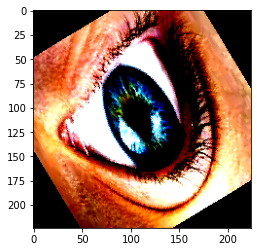

In [12]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[10][0].permute(1, 2, 0))
print(pred2label[train_dataset[10][1].item()])

In [13]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)          
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [14]:
class EfficientNetB0(ClassificationBase):
    
    def __init__(self):
        super().__init__()
        
        self.network = timm.create_model('efficientnet_b0', pretrained=True)
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, n_classes)
        
        
    def forward(self, batch):
        batch = batch.to(device)
        return torch.sigmoid(self.network(batch))
        
        
        
model = EfficientNetB0()     

In [15]:
def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), 3e-4)
    for epoch in range(epochs):
        lrs = []
        loss = 0
        acc = 0
        for batch in tqdm.tqdm(train_loader):
            loss, acc = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, loss, acc))
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = model.to(device)

In [17]:
evaluate(model, test_dataloader)

{'val_loss': 1.3930197954177856, 'val_acc': 0.23529411852359772}

In [18]:
import tqdm
history = fit(10, model, train_dataloader, test_dataloader)

100%|████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Epoch [0], loss: 1.2551, acc: 0.8049
Epoch [0], val_loss: 1.2682, val_acc: 0.6471


100%|████████████████████████████████████████████████| 5/5 [02:04<00:00, 24.81s/it]


Epoch [1], loss: 1.0949, acc: 0.8293
Epoch [1], val_loss: 1.1407, val_acc: 0.6765


100%|████████████████████████████████████████████████| 5/5 [02:43<00:00, 32.64s/it]


Epoch [2], loss: 0.9770, acc: 0.9268
Epoch [2], val_loss: 1.0532, val_acc: 0.6765


100%|████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.13s/it]


Epoch [3], loss: 0.9656, acc: 0.8049
Epoch [3], val_loss: 1.0127, val_acc: 0.7059


100%|████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.02s/it]


Epoch [4], loss: 0.9195, acc: 0.9024
Epoch [4], val_loss: 1.0044, val_acc: 0.7059


100%|████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.15s/it]


Epoch [5], loss: 0.8515, acc: 0.9268
Epoch [5], val_loss: 1.0013, val_acc: 0.6765


100%|████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.13s/it]


Epoch [6], loss: 0.8476, acc: 0.9024
Epoch [6], val_loss: 1.0016, val_acc: 0.7353


100%|████████████████████████████████████████████████| 5/5 [02:01<00:00, 24.22s/it]


Epoch [7], loss: 0.8192, acc: 0.9024
Epoch [7], val_loss: 1.0022, val_acc: 0.7059


100%|████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.87s/it]


Epoch [8], loss: 0.7912, acc: 0.9756
Epoch [8], val_loss: 1.0015, val_acc: 0.7353


100%|████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.51s/it]


Epoch [9], loss: 0.7730, acc: 1.0000
Epoch [9], val_loss: 1.0156, val_acc: 0.7059


In [20]:
torch.save(model.state_dict(), 'model_1.pth')